# Certificate in Data Science | Assignment 5 |  
- Hypothesis Simulation 

> University of Washington  
> September 2019  
> N. HICKS

## Instructions
Use the <a href="https://archive.ics.uci.edu/ml/datasets/Automobile">automotive data set</a> to perform the following:

1. Identify a likely distribution for price and several other features.
2. Compute basic summary statistics by both classical, bootstrap, and Bayesian methods
3. Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods
4. Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:
       - Classical tests
       - Tukey’s Honest Significant Differences (HSD)
       - Bootstrap methods
       - Bayesian model


Note:  
Please clearly outline the results with markdown text. Be sure your discussion includes narrative for your figures and tables so it is clear to the reader the importance of each bit of evidence.

## Import the Libraries

In [2]:
# Load necessary libraries
import qgrid
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn import preprocessing
import sys
import warnings
import scipy
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# import statsmodels.stats.power as smsp
# from scipy import stats

In [2]:
# establish the Notebook theme
#jt -t onedork -T -cellw 75% -ofs 11 -dfs 9

## Setup the  Problem Statement & Inputs

### Functions for Scripting

In [3]:
# supress warnings
def supressWarnings():
    if not sys.warnoptions:
        warnings.simplefilter("ignore")


# Normalize a feature column
def get_normFeature(feature):
    x_array = np.array(feature)
    normalized_X = preprocessing.normalize([x_array])
    return normalized_X


# ensure missing values and special characters are handled, to enable further dataframe processing
def scrubFeatures(df, features):    
    # check the specified feature of the dataframe for missing values
    for item in features:
        if item == 'price':
            val = 1
        elif item == 'num-of-cylinders':
            cylinders = ['two', 'three', 'four', 'five', 'six', 'eight', 'twelve']
            for cylinder in cylinders:
                if cylinder=='two': val = 2
                if cylinder=='three': val = 3
                if cylinder=='four': val = 4
                if cylinder=='five': val = 5
                if cylinder=='six': val = 6
                if cylinder=='eight': val = 8
                if cylinder=='twelve': val = 12
                df.replace(cylinder, val, inplace=True)
        elif item == 'engine-location':
            locations = ['front', 'rear']
            for loc in locations:
                if loc=='front': val = 1
                if loc=='rear': val = 0
                df.replace(loc, val, inplace=True)
        else:
            val = 0
        df.replace('?', val, inplace=True)
        df.fillna(val, inplace=True)
        df = df.astype({item:int})
    # check the remainder of the dataframe for missing values
    val = 0
    df.replace('?', val, inplace=True)
    df.fillna(val, inplace=True)
    return df


# establish a new calculated feature: the Log of Auto Price, per this assignment requirement 1
def logFeature(df, feature):
    for item in feature:
        logList = np.log(df[item])
        locPrice = df.columns.get_loc(item)
        name = 'log_' + item
        df.insert(loc=locPrice+1, column=name, value=logList)
    return df

In [4]:
# return a histogram plot of the specified format
def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')


# plot a comparison of 2 histogram populations
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 25):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    # change the figure dimensions
    plt.figure(figsize=figArea)
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograms of Automobile ' + cols[0] + ' and ' + cols[1], fontsize='14')
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    
    plt.show()

In [5]:
# return a qGrid dataframe based on specified columns/features
def get_qGrid(df, features):
    temp_df = pd.DataFrame(df[features[0]])
    features.remove(features[0])
    for feature in features:
        temp_df = pd.concat([temp_df, df[feature]], axis=1)
    qGrid = qgrid.show_grid(temp_df)
    return qGrid

### Set Default Output Parameters

In [6]:
%matplotlib inline
sns.set()
supressWarnings()
figArea = (15,7)   # width, height of the resulting plots

### Import & Describe the DataFrame  
> Locate and import the source data to a dataframe.

In [9]:
# Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu//DATASCI410//Datasets//Automobile_Price_Data_Raw_.csv"
try:
    # import the file to a dataframe
    auto_df = pd.read_csv(fileName)
    print('REMOTE FILE USED')
except:
    # Local Copy -- Link would not permit access
    fileName = 'C://Users//NateDogg//Desktop//_notebooks//Automobile_Price_Data_Raw.csv'
    print('LOCAL FILE USED\n--> remote server is unavailable')
# import the file to a dataframe
auto_df = pd.read_csv(fileName)

LOCAL FILE USED
--> remote server is unavailable


In [8]:
auto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
symboling            205 non-null int64
normalized-losses    205 non-null object
make                 205 non-null object
fuel-type            205 non-null object
aspiration           205 non-null object
num-of-doors         205 non-null object
body-style           205 non-null object
drive-wheels         205 non-null object
engine-location      205 non-null object
wheel-base           205 non-null float64
length               205 non-null float64
width                205 non-null float64
height               205 non-null float64
curb-weight          205 non-null int64
engine-type          205 non-null object
num-of-cylinders     205 non-null object
engine-size          205 non-null int64
fuel-system          205 non-null object
bore                 205 non-null object
stroke               205 non-null object
compression-ratio    205 non-null float64
horsepower           205 non-nul

### Clean the DataFrame  
> - Clean-up the dataframe for missing values.  
> - Using qGrid library permits quick visibility of missing entries within the column via filtering.  
> - This initial qGrid reflects prior works accomplished upon this same dataset, upon the column features shown here.

In [9]:
# cleanup the dataframe for missing values
whiteList = ['price', 'num-of-cylinders', 'engine-location']   # a white list of unique variable assignments, for dataframe calculations that require Natural Log
auto_df = scrubFeatures(auto_df, whiteList)

# establish a new calculated feature: the Log of Auto Price, per this assignment requirement 1
auto_df = logFeature(auto_df, ['price'])

# view the dataframe via qGrid
colNames = ['price', 'log_price', 'fuel-type', 'make',
            'aspiration', 'body-style', 'drive-wheels'
           ]
autoPast_qGrid = get_qGrid(auto_df, colNames)
autoPast_qGrid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Prior Implemented Works  
> - Prior works initially substantiated the 'Price' and 'Log Price' of the automobile purchase prices, to compare their level of statistical significance.

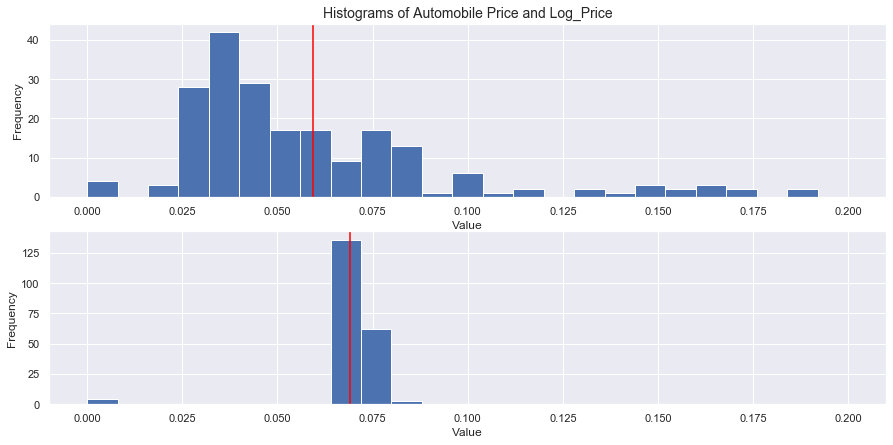

In [10]:
# show the population of the derived PRICE and LOG_PRICE features
pop_A = auto_df['price']
pop_B = auto_df['log_price']
# return the normalized series of specified populations
norm_A = get_normFeature(pop_A)
norm_B = get_normFeature(pop_B)
norm_A = norm_A[0]
norm_B = norm_B[0]

# plot histograms using normalized data
plot_pop(norm_A, norm_B, cols=['Price', 'Log_Price']) 

### Newly Implemented Works  
> - The dataset is established in 3 primary categories, which are shown in the qGrid below.  
> - Using the qGrid library permits quick filtering of the column features for idenbtification of missing values.

In [11]:
# evaluate 'Log_Price' vs. 'Symboling' and 'Normalized Losses' via normalized histogram plots
# view the dataframe via qGrid
colNames = ['log_price', 'symboling', 'normalized-losses'
           ]
autoNew0_qGrid = get_qGrid(auto_df, colNames)
autoNew0_qGrid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

#### Symboling  
> - Evaluation of the 'Symboling' feature via histigram plots.

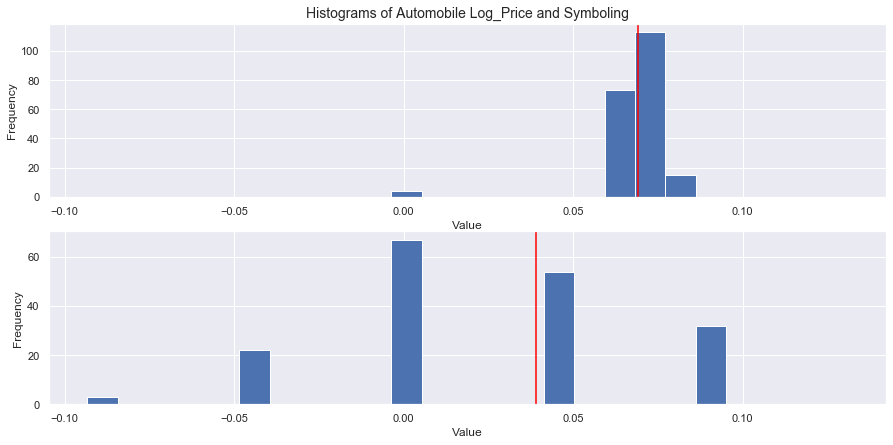

In [12]:
# show the population of the derived 'Log_Price' and 'Symboling' features
pop_C = auto_df['symboling']
# return the normalized series of specified populations
norm_C = get_normFeature(pop_C)
norm_C = norm_C[0]

# plot histograms using normalized data
plot_pop(norm_B, norm_C, cols=['Log_Price', 'Symboling']) 

#### Normalized Losses  
> - Evaluation of the 'Normalized Losses' feature via histigram plots.

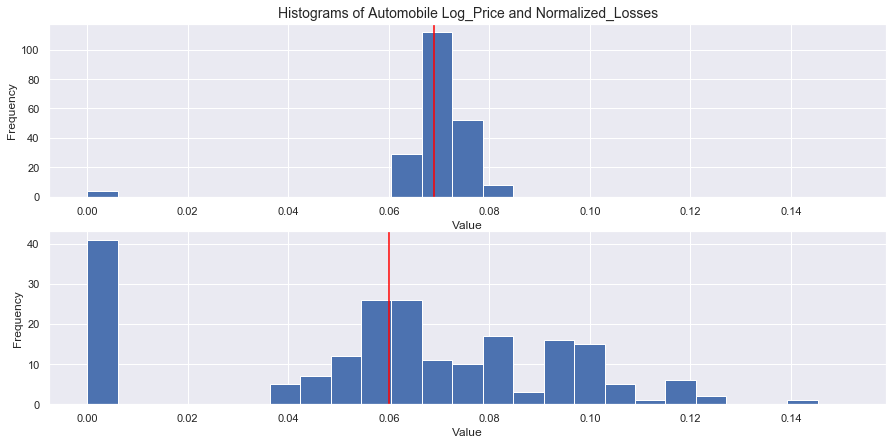

In [13]:
# show the population of the derived PRICE and LOG_PRICE features
pop_D = auto_df['normalized-losses']
# return the normalized series of specified populations
norm_D = get_normFeature(pop_D)
norm_D = norm_D[0]

# plot histograms using normalized data
plot_pop(norm_B, norm_D, cols=['Log_Price', 'Normalized_Losses'])

## Question 1 - A Distribution  
---
> - ***Identify a likely distribution for price and several other features.***  
  
> - First, using qGrids to inspect the dataframe elements, of the features that initially might seem correlated.

In [14]:
# the primary features perceived correlated with features 'Symboling' and Normalized-Losses'
# are shown here via the dataframe qGrid view
colNames = ['engine-size', 'num-of-cylinders', 'curb-weight',
            'length', 'width', 'height', 'wheel-base', 'engine-location'
           ]
autoNew1_qGrid = get_qGrid(auto_df, colNames)
autoNew1_qGrid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [15]:
# the primary features perceived correlated with features 'Symboling' and Normalized-Losses'
# are shown here via the dataframe qGrid view
colNames = ['engine-size', 'engine-type',
            'bore', 'stroke', 'horsepower', 'city-mpg', 'compression-ratio'
           ]
autoNew2_qGrid = get_qGrid(auto_df, colNames)
autoNew2_qGrid

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### Functions for Scripting

In [16]:
# return box plots of the specified dtaframe features
def get_boxPlot(df, features):
    plt.figure(figsize=figArea)
    df.boxplot(column=features)
    plt.ylabel('Normalized Value\n', fontsize=13)
    plt.xlabel('\nAutomobile Feature', fontsize=13)
    plt.title('Box Plots by Specified Automobile Features', fontsize=14)
    locs = np.arange(1,len(features),1)
    if len(features)>10:
        plt.xticks(rotation=30)
    plt.show()


def get_boxFeatures(stratified, categories, stratFeature, unitFeature):
    stratified.reset_index(inplace=True, drop=True)
    cols_df = pd.DataFrame(columns=categories)

    for item in categories:
        strat_standard = stratified[stratFeature] == item
        strat_standard = stratified[strat_standard]
        strat_standard.reset_index(inplace=True, drop=True)
        print('\ncategory: ' + str(item), '\nsamples: ' + str(strat_standard.shape[0]))

        norm_item = get_normFeature(strat_standard[unitFeature])
        cols_df[item] = norm_item[0]
        
    return cols_df


# stratify the dataframe by the given category
def stratify(df, p, category):
    groups = df.groupby(category) # Create the groups
    nums = min(groups.size()) # Find the size of the smallest group
    num = int(p * df.shape[0]) # Compute the desired number of samples per group
    if num <= nums: # If sufficient group size, sample each group and return. 
        return groups.apply(lambda x: x.sample(n=num))
    else: # Oops. p is to large
        pmax = nums / df.shape[0]
        print('   - Chosen p value is too large.')
        print('     The maximum value is p = ' + str(pmax))

### Box Plots  
> - Gain further insight to the datasets features and distributions.  
> - This perspective helps establish appropriate distribution models per the problem statement requirement. 

> - plot below shows the perspective developed upon 'Symboling'

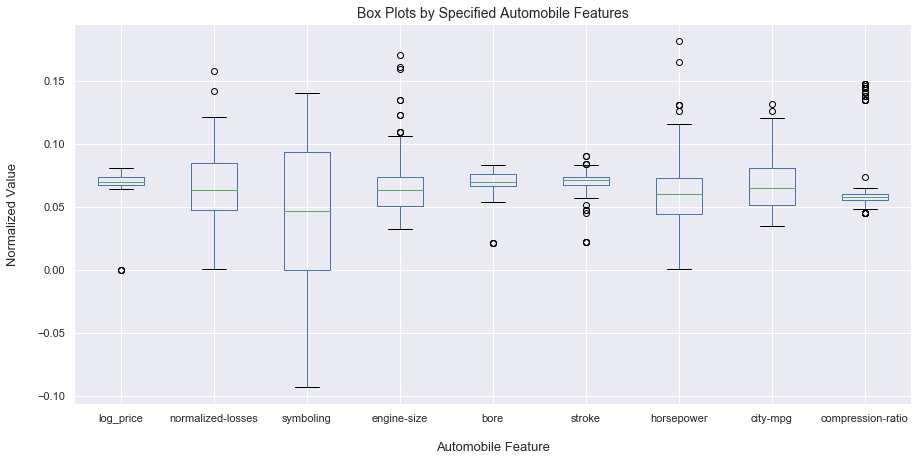

In [17]:
# establish dataset feature boxplots
colNames_Symboling = ['log_price', 'normalized-losses', 'symboling', 'engine-size',
                      'bore', 'stroke', 'horsepower', 'city-mpg', 'compression-ratio'
                     ]
symboling_df = pd.DataFrame(columns=colNames_Symboling)
for item in colNames_Symboling:
    norm_item = get_normFeature(auto_df[item])
    symboling_df[item] = norm_item[0]

get_boxPlot(symboling_df, colNames_Symboling)

> - The automobile features shown below indicate the relationships of the 'Engine-Type' feature and with the perspective of 'Normalized Loss'


category: dohc 
samples: 12

category: l 
samples: 12

category: ohc 
samples: 12

category: ohcf 
samples: 12

category: ohcv 
samples: 12


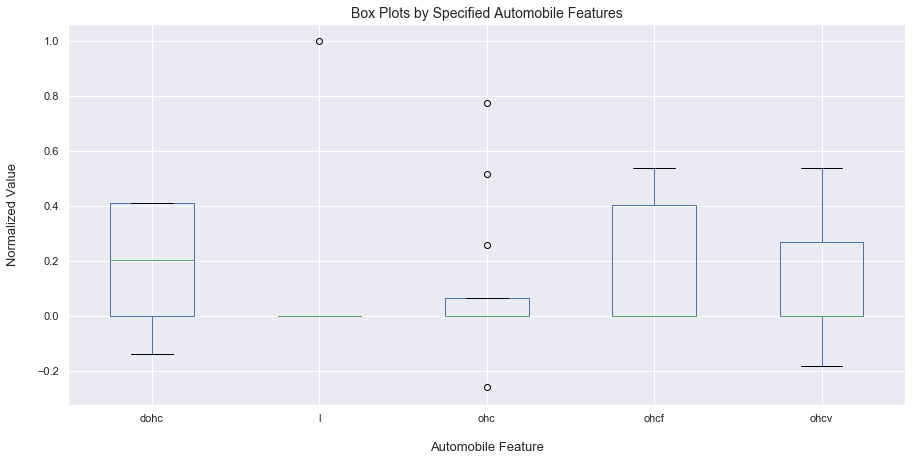

In [18]:
"""
return the 'Engine-Type' feature via boxplot, using stratification
"""

# remove the following categories due to small sample size
auto0_df = auto_df[auto_df['engine-type'] != 'dohcv']    # not enough samples to establish stratification using this feature
auto0_df = auto0_df[auto_df['engine-type'] != 'rotor']   # not enough samples to establish stratification using this feature

# establish categories for the box plot data
p=.06
categories = ['dohc', 'l', 'ohc', 'ohcf', 'ohcv']
stratified = stratify(auto0_df, p, 'engine-type')

try:
    if stratified==None:
        print('\n   - Empty dataframe resultant from \n     stratification sampling.')
except:
    if  stratified.empty:
        print('\n   - Empty dataframe resultant from \n     stratification sampling.')
    elif len(stratified.index)>0:
        boxFeatures = get_boxFeatures(stratified, categories, 'engine-type', 'symboling')
        get_boxPlot(boxFeatures, categories)

> - plot below shows the perspective developed upon 'Normalized Losses'

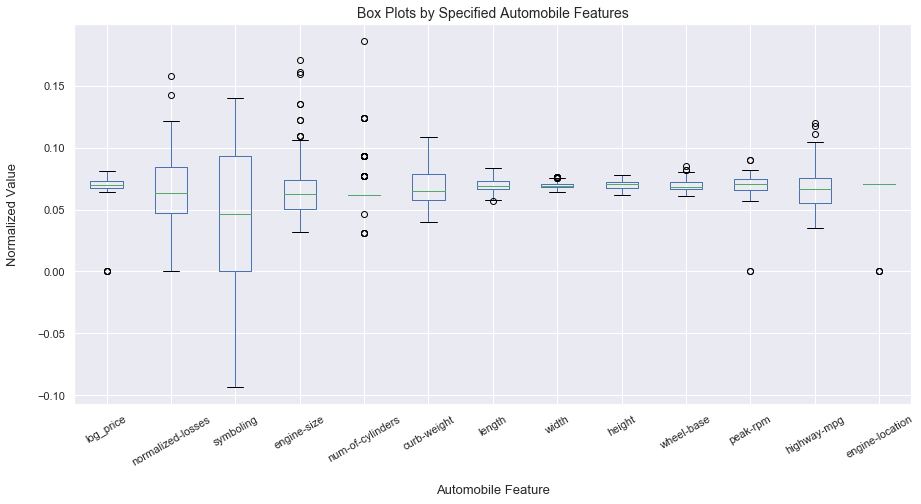

In [19]:
# establish dataset feature boxplots
colNames_Losses = ['log_price', 'normalized-losses', 'symboling', 'engine-size',
                   'num-of-cylinders', 'curb-weight', 'length', 'width', 'height',
                   'wheel-base', 'peak-rpm', 'highway-mpg', 'engine-location'
                  ]
losses_df = pd.DataFrame(columns=colNames_Losses)
for item in colNames_Losses:
    norm_item = get_normFeature(auto_df[item])
    losses_df[item] = norm_item[0]

get_boxPlot(losses_df, colNames_Losses)

> - Most noticeably, the above plot result reflects that the 'Symboling' feature has the lowest mean and widest distribution of all features shown.  
> - However, the means of the distributions are generally similar overall, suggesting that a single distribution model can indeed be applied to the dataset features. 

### Selecting a Distribution Model  
- Log-Normal Distribution as the selected model.  
> - Features such as 'Price', 'Weight', 'Length', and 'Volume' are suitable for a log-normal distribution.  
> - A Log-normal distribution accepts only positive-valued magnitudes, with the majority of those distributed nearer to zero, as shown below.  
> - Therfore, the auto dataset features are appropriately suited for a log-normal distribution given that the means of the features shown above, are approximately (REF: Box Plots).

Text(0.5, 1.0, 'Density of std Log-Normal')

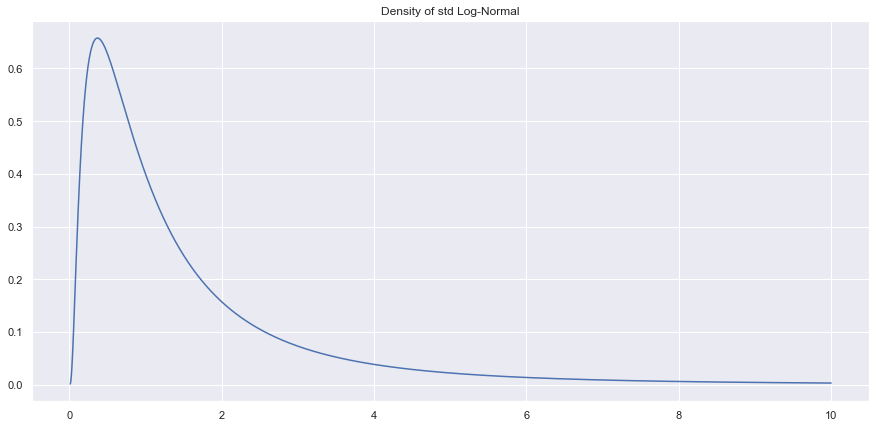

In [20]:
x = np.linspace(.01, 10, num=100000)
plt.figure(figsize=figArea)
log_normal_pdf = scipy.stats.lognorm.pdf(x, 1)
plt.plot(x, log_normal_pdf)
plt.title('Density of std Log-Normal')

## Question 2 - Summary Statistics  
---
> ***Compute basic summary statistics by both classical, bootstrap, and Bayesian methods.***  
> - Classically @ *.describe()  
> - Boostrap    @  *.sample()  
> - Bayesian    @  prior = log-normal distribution

### Functions for Scripting

In [21]:
# return the Bootstrap summary statistics
def bootStats(stats_df, labels):
    # establish the dataframe structure for returning the bootstrap summary statistics
    df = pd.DataFrame()
    n_replicas = 1000

    # bootstrap the means
    bs_means = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).mean() for i in range(n_replicas)])
    bs_means = bs_means.mean()

    # bootstrap the standard deviations
    bs_deviations = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).std() for i in range(n_replicas)])
    bs_deviations = bs_deviations.std()
    
    # bootstrap the quantiles
    bs_quantile25 = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).quantile(0.25, axis=0) for i in range(n_replicas)])
    bs_quantile25 = bs_quantile25.quantile(0.25, axis=0)
    
    bs_quantile50 = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).quantile(0.50, axis=0) for i in range(n_replicas)])
    bs_quantile50 = bs_quantile50.quantile(0.50, axis=0)
    
    bs_quantile75 = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).quantile(0.75, axis=0) for i in range(n_replicas)])
    bs_quantile75 = bs_quantile75.quantile(0.75, axis=0)
    
    # bootstrap the min/max values
    bs_min = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).min() for i in range(n_replicas)])
    bs_min = bs_min.min()

    bs_max = pd.DataFrame([
        stats_df.sample(frac=1, replace=True).max() for i in range(n_replicas)])
    bs_max = bs_max.max()

    # assign the statistical results to the DataFrame
    results = [bs_means, bs_deviations, bs_min, bs_quantile25, bs_quantile50, bs_quantile75, bs_max]
    i = 0
    for items in results:
        j = 0
        for data in items:
            df.loc[i,j] = data
            j += 1
        i += 1

    # rename the columns
    df.columns = labels
    # reset the dataframe indices
    df.rename(index={0:'mean', 1:'std', 2: 'min', 3:'25%', 4:'50%', 5:'75%', 6:'max'}, inplace=True)
    print('--------------')
    print('-------------- SUMMARY STATISTICS FOR BOOTSTRAP APPROACH ----------------')
    print('--------------')
    return df

# return the Bayes summary statistics
def bayesStats(stats_df, labels):
    df = pd.DataFrame(columns=labels)
    stats_df = pd.DataFrame()

    for item in labels:
        x = classicalStats_df[item]
        log_normal_pdf = scipy.stats.lognorm.pdf(x, 1)
        df[item] = log_normal_pdf

    # return the means and standard deviations of the log-normal distribution
    bayes_means = df.mean()
    bayes_deviations = df.std()
    
    # return the quantiles derived via the log-normal distribution
    bayes_quantile25 = df.quantile(0.25, axis=0)
    bayes_quantile50 = df.quantile(0.50, axis=0)
    bayes_quantile75 = df.quantile(0.75, axis=0)
    
    # return the min/max values of the log-normal distribution
    bayes_min = df.min()
    bayes_max = df.max()

    results = [bayes_means, bayes_deviations, bayes_min,
               bayes_quantile25, bayes_quantile50, bayes_quantile75, bayes_max]
    i = 0
    for items in results:
            j = 0
            for data in items:
                stats_df.loc[i, j] = data
                j += 1
            i += 1

    # rename the columns
    stats_df.columns = labels
    # reset the dataframe indices
    stats_df.rename(index={0:'mean', 1:'std', 2: 'min', 3:'25%', 4:'50%', 5:'75%', 6:'max'}, inplace=True)
    print('--------------')
    print('-------------- SUMMARY STATISTICS FOR BAYESIAN APPROACH ----------------')
    print('--------------')
    return stats_df

### Classical Summary Statistics

In [1]:
# establish the dataframe to evaluate statistically
symbols_df = symboling_df.iloc[:,4:len(symboling_df.index)]
# derive the colum names as a list, to re-name the final dataframe features once again
strFeatures = list(losses_df.columns.values)
symbolNames = list(symbols_df.columns.values)
for i in symbolNames:
    strFeatures.append(i)
    
classicalStats_df =  pd.concat([losses_df, symbols_df],
                               axis=1, ignore_index=True, sort=False
                              )
classicalStats_df.columns = strFeatures # and finally, re-name the dataframe features

# generate the classic summary statistics, as required
print('--------------')
print('-------------- SUMMARY STATISTICS FOR CLASSICAL APPROACH ----------------')
print('--------------')
classicalStats_Summary_df = classicalStats_df.describe()
classicalStats_Summary_df = classicalStats_Summary_df.drop(['count'],axis=0)
classicalStats_Summary_df

NameError: name 'symboling_df' is not defined

### Bootstrap Summary Statistics  
> - mean  
> - standard deviation  
> - min / max  
> - quantile: 25, 50, 75
  
> - Establish a DataFrame to return the results  
> - Observe and compare the similarity in results between this Boostrap method and the prior Classical method.

In [23]:
bootstrapStats_df = bootStats(classicalStats_df, strFeatures)
bootstrapStats_df

--------------
-------------- SUMMARY STATISTICS FOR BOOTSTRAP APPROACH ----------------
--------------


,log_price,normalized-losses,symboling,engine-size,num-of-cylinders,curb-weight,length,width,height,wheel-base,peak-rpm,highway-mpg,engine-location,bore,stroke,horsepower,city-mpg,compression-ratio
mean,0.053170,0.064812,0.041285,0.069113,0.070555,0.062114,0.060730,0.060265,0.060539,0.061365,0.054604,0.062767,0.051509,0.056495,0.057612,0.065178,0.064454,0.065876
std,0.008393,0.014982,0.020296,0.017934,0.021248,0.007454,0.010145,0.012064,0.011568,0.010738,0.008210,0.008618,0.009023,0.007077,0.007063,0.019881,0.010094,0.015361
min,0.000000,0.000615,-0.093352,0.021781,0.016734,0.013945,0.004938,0.002272,0.003173,0.004251,0.000014,0.015264,0.000000,0.008892,0.009542,0.000629,0.017540,0.025477
25%,0.010460,0.030370,-0.023338,0.031905,0.030964,0.039299,0.037134,0.035823,0.036472,0.036363,0.009470,0.035465,0.008470,0.021094,0.021545,0.025681,0.034854,0.041602
50%,0.069059,0.060126,0.046676,0.062765,0.061928,0.064652,0.069329,0.069374,0.069771,0.068474,0.069201,0.066498,0.070360,0.069277,0.069191,0.059784,0.064346,0.057727
75%,0.074918,0.108756,0.093352,0.116638,0.123856,0.086774,0.076314,0.072975,0.073716,0.076910,0.079595,0.093097,0.070360,0.076193,0.079518,0.120512,0.097860,0.102625
max,0.080777,0.157385,0.140028,0.170511,0.185784,0.108896,0.083299,0.076577,0.077661,0.085346,0.089989,0.119696,0.070360,0.083109,0.089844,0.181240,0.131373,0.147524


### Bayesian Summary Statstics  
> - The Bayesian statistics are derived via the previously identified log-normal distribution, that models the auto dataset reasonably well.  
> - The histograms below show that a log-normal distribution behaves as expected upon the auto dataset feature 'Log_Price'.  
> - The dataframe views give the summary statistics, as required.

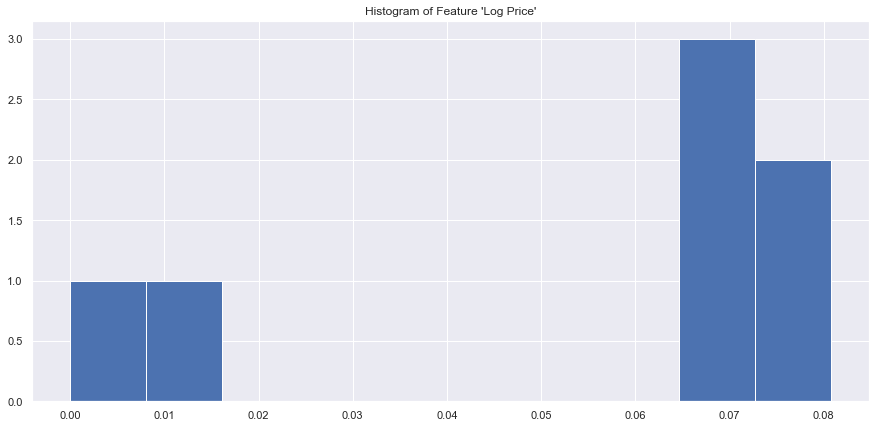

In [24]:
x = classicalStats_df['log_price']
plt.figure(figsize=figArea)
plt.hist(x)
plt.title('Histogram of Feature \'Log Price\'')
plt.show()

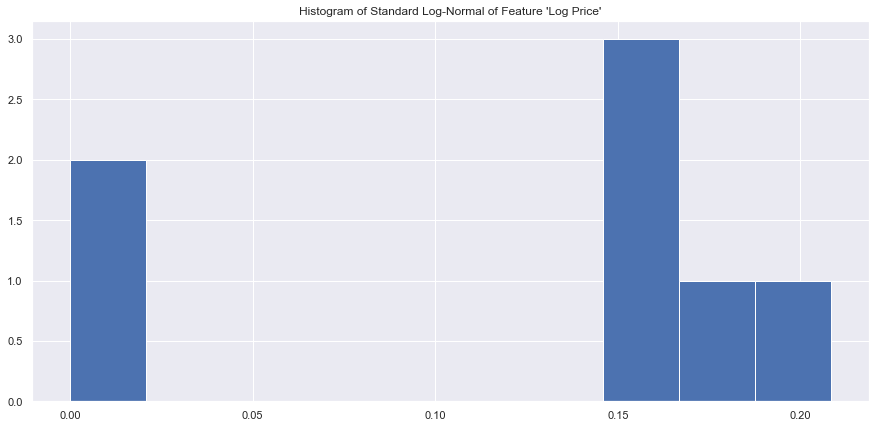

In [25]:
log_normal_pdf = scipy.stats.lognorm.pdf(x, 1)
plt.figure(figsize=figArea)
plt.hist(log_normal_pdf)
plt.title('Histogram of Standard Log-Normal of Feature \'Log Price\'')
plt.show()

In [26]:
bayesStats_df = bayesStats(classicalStats_df, strFeatures)
bayesStats_df

--------------
-------------- SUMMARY STATISTICS FOR BAYESIAN APPROACH ----------------
--------------


,log_price,normalized-losses,symboling,engine-size,num-of-cylinders,curb-weight,length,width,height,wheel-base,peak-rpm,highway-mpg,engine-location,bore,stroke,horsepower,city-mpg,compression-ratio
mean,0.124344,1.530648e-01,0.131452,0.156768,0.159725,0.142068,0.141670,0.141427,0.142005,0.144397,1.301790e-01,0.143560,0.119111,0.127993,0.131662,1.500793e-01,0.147891,0.146538
std,0.086271,1.526275e-01,0.151909,0.159146,0.169670,0.100383,0.069789,0.064114,0.065263,0.069983,9.370655e-02,0.112304,0.081199,0.086236,0.090555,1.725079e-01,0.126005,0.133346
min,0.000000,8.704015e-10,0.000000,0.012105,0.005550,0.003107,0.000061,0.000002,0.000008,0.000031,1.633947e-23,0.004160,0.000000,0.000644,0.000835,1.010249e-09,0.006411,0.018623
25%,0.078495,6.173286e-02,0.026409,0.062766,0.082621,0.086474,0.133104,0.149881,0.145699,0.142263,7.449254e-02,0.076146,0.081972,0.080739,0.082587,4.409530e-02,0.067052,0.090352
50%,0.162341,1.275351e-01,0.078076,0.137725,0.134484,0.145071,0.163403,0.163581,0.165142,0.160042,1.628996e-01,0.152286,0.167459,0.163200,0.162861,1.262224e-01,0.143877,0.118368
75%,0.171324,1.808831e-01,0.188366,0.166312,0.145976,0.179920,0.171875,0.167349,0.170640,0.169982,1.776450e-01,0.172996,0.167459,0.176550,0.174618,1.620945e-01,0.181876,0.137408
max,0.208429,4.586862e-01,0.412536,0.489394,0.520847,0.313512,0.218270,0.191945,0.196208,0.226216,2.440780e-01,0.350190,0.167459,0.217529,0.243526,5.119533e-01,0.387093,0.433257


## Question 3 - Confidence Intervals  
---
> ***Compute confidence intervals for these summary statistics by classical, bootstrap, and Bayesian methods.***

### Functions for Scripting

In [27]:
# return the lower and upper limits of the confidence interval
def get_intervals(df, labels):
    Z_95 = 1.96
    stats_df = pd.DataFrame()
    j = 0
    for item in labels:
        i = 0
        mean = df[item][0]
        upper = mean + (Z_95 * df[item][1])   # the upper limit of the confidence interval
        lower = mean - (Z_95 * df[item][1])   # the lower limit of the confidence interval
        for data in [lower, mean, upper]:
            stats_df.loc[i, j] = data
            i += 1
        j += 1

    # rename the columns
    stats_df.columns = labels
    # reset the dataframe indices
    stats_df.rename(index={0:'lower_ci', 1:'mean', 2: 'upper_ci'}, inplace=True)
    
    return stats_df

### Classical Confidence Intervals

In [28]:
classical_confLimits = get_intervals(classicalStats_df, strFeatures)
classical_confLimits

,log_price,normalized-losses,symboling,engine-size,num-of-cylinders,curb-weight,length,width,height,wheel-base,peak-rpm,highway-mpg,engine-location,bore,stroke,horsepower,city-mpg,compression-ratio
lower_ci,0.048558,-0.009698,-0.074992,0.023687,0.035021,0.041112,0.059990,0.065353,0.063551,0.061382,0.050639,0.038245,0.052729,0.051849,0.050489,0.014641,0.033237,0.015120
mean,0.069059,0.060126,0.038935,0.066377,0.067819,0.068444,0.069669,0.069806,0.069771,0.069714,0.069201,0.068163,0.069330,0.069277,0.069191,0.064975,0.067616,0.065055
upper_ci,0.089560,0.129950,0.152861,0.109068,0.100617,0.095776,0.079348,0.074260,0.075991,0.078046,0.087763,0.098081,0.085931,0.086706,0.087894,0.115309,0.101994,0.114990


### Bootstrap Confidence Intervals

In [29]:
bootstrap_confLimits = get_intervals(bootstrapStats_df, strFeatures)
bootstrap_confLimits

,log_price,normalized-losses,symboling,engine-size,num-of-cylinders,curb-weight,length,width,height,wheel-base,peak-rpm,highway-mpg,engine-location,bore,stroke,horsepower,city-mpg,compression-ratio
lower_ci,0.03672,0.035448,0.001506,0.033961,0.028909,0.047503,0.040845,0.036621,0.037866,0.040318,0.038512,0.045876,0.033824,0.042624,0.043769,0.026211,0.044670,0.035768
mean,0.05317,0.064812,0.041285,0.069113,0.070555,0.062114,0.060730,0.060265,0.060539,0.061365,0.054604,0.062767,0.051509,0.056495,0.057612,0.065178,0.064454,0.065876
upper_ci,0.06962,0.094176,0.081065,0.104264,0.112201,0.076725,0.080615,0.083910,0.083211,0.082412,0.070697,0.079658,0.069194,0.070366,0.071455,0.104145,0.084237,0.095983


### Bayesian Confidence Intervals

In [30]:
bayes_confLimits = get_intervals(bayesStats_df, strFeatures)
bayes_confLimits

,log_price,normalized-losses,symboling,engine-size,num-of-cylinders,curb-weight,length,width,height,wheel-base,peak-rpm,highway-mpg,engine-location,bore,stroke,horsepower,city-mpg,compression-ratio
lower_ci,-0.044748,-0.146085,-0.166289,-0.155158,-0.172829,-0.054682,0.004883,0.015764,0.014089,0.007231,-0.053486,-0.076556,-0.040038,-0.041030,-0.045825,-0.188036,-0.099080,-0.114820
mean,0.124344,0.153065,0.131452,0.156768,0.159725,0.142068,0.141670,0.141427,0.142005,0.144397,0.130179,0.143560,0.119111,0.127993,0.131662,0.150079,0.147891,0.146538
upper_ci,0.293436,0.452215,0.429192,0.468694,0.492279,0.338819,0.278457,0.267089,0.269921,0.281564,0.313844,0.363676,0.278261,0.297015,0.309149,0.488195,0.394862,0.407897


## Question 4 - Hypothesis Testing  
---
> ***Correctly use hypothesis tests to determine if the differences in pairs and multiple populations are significant:***  
> - Classical tests  
> - Tukey’s Honest Significant Differences (HSD)  
> - Bootstrap methods  
> - Bayesian model

### Functions for Scripting

In [2]:
# use a t-test to compare hypothesis test outcomes
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()
    res = ss.ttest_ind(a, b, equal_var=False)
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(
        alpha=alpha, alternative=alternative, usevar='unequal')
    degfree = means.dof_satt()
    index = ['DegFreedom', 'Difference',
             't-Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index=index)


def helper_tTest(df, features):
    pop_A = df[features[0]]
    pop_B = df[features[1]]
    # return the normalized series of specified populations
    norm_A = get_normFeature(pop_A)
    norm_B = get_normFeature(pop_B)
    norm_A = norm_A[0]
    norm_B = norm_B[0]
    t_testResult = t_test(norm_A, norm_B, 0.05)
    print(t_testResult)
    plot_t(norm_A, norm_B, t_testResult, cols=features)


def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins=bins)
    plt.axvline(mean(vec), color='red')
    plt.axvline(upper, color='red', linestyle='--')
    plt.axvline(lower, color='red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')


def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins=20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.figure(figsize=figArea)
    plt.subplot(2, 1, 1)  # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograms of ' + str(cols[0]) + ' and ' + str(cols[1]), fontsize='14')
    plt.subplot(2, 1, 2)  # The next plot
    hist_plot(b, bins)
    plt.show()

In [32]:
# these functions support the TUKEY'S HSD hypothesis test results
def norm_Helper(df, feature):
    data = df[feature]
    norm = get_normFeature(data)
    norm = norm[0].tolist()
    return norm


def get_Groups(df):
    data1 = norm_Helper(df, 'log_price')
    data2 = norm_Helper(df, 'normalized-losses')
    data3 = norm_Helper(df, 'symboling')
    data4 = norm_Helper(df, 'curb-weight')
    data5 = norm_Helper(df, 'length')
    data6 = norm_Helper(df, 'width')
    data7 = norm_Helper(df, 'height')
    data8 = norm_Helper(df, 'wheel-base')
    data9 = norm_Helper(df, 'city-mpg')
    data10 = norm_Helper(df, 'highway-mpg')
    data11 = norm_Helper(df, 'engine-location')
    data12 = norm_Helper(df, 'engine-size')
    data13 = norm_Helper(df, 'num-of-cylinders')
    data14 = norm_Helper(df, 'bore')
    data15 = norm_Helper(df, 'stroke')
    data16 = norm_Helper(df, 'horsepower')
    data17 = norm_Helper(df, 'compression-ratio')
    data18 = norm_Helper(df, 'peak-rpm')
    
    lenFeature = len(data1)
    temp_df = pd.DataFrame({'vals': data1 + data2 + data3 + data4 + data5 + data6
                            + data7 + data8 + data9 + data10 + data11 + data12 + data13
                            + data14 + data15 + data16 + data17 + data18,
                            'group_num': ['  log_price  '] * lenFeature
                            + ['  norm-losses  '] * lenFeature
                            + ['  symboling  '] * lenFeature
                            + ['  curb-weight  '] * lenFeature
                            + ['  length  '] * lenFeature
                            + ['  width  '] * lenFeature
                            + ['  height  '] * lenFeature
                            + ['  wheel-base  '] * lenFeature
                            + ['  city-mpg  '] * lenFeature
                            + ['  highway-mpg  '] * lenFeature
                            + ['  engine-loction  '] * lenFeature
                            + ['  engine-size  '] * lenFeature
                            + ['  num-cylinders  '] * lenFeature
                            + ['  bore  '] * lenFeature
                            + ['  stroke  '] * lenFeature
                            + ['  horsepower  '] * lenFeature
                            + ['  compression-ratio  '] * lenFeature
                            + ['  peak-rpm  '] * lenFeature
                           })    
    return temp_df

In [33]:
# return the log-normal distribution of the samples
def get_LogNormal(df, labels):
    # ensure all features are converted to the correct data type
    df['normalized-losses'] = pd.to_numeric(auto_df['normalized-losses'])
    df['peak-rpm'] = pd.to_numeric(auto_df['peak-rpm'])
    df['horsepower'] = pd.to_numeric(auto_df['horsepower'])
    df['stroke'] = pd.to_numeric(auto_df['stroke'])
    df['bore'] = pd.to_numeric(auto_df['bore'])

    temp_df = pd.DataFrame(columns=labels)
    for item in labels:
        x = df[item]
        log_normal_pdf = scipy.stats.lognorm.pdf(x, 1)
        temp_df[item] = log_normal_pdf
    return temp_df

### Classical Hypothesis Test  
> - The t-test is employed for the classical approach to hypothesis testing.  
> - Various aspects of the auto dataset are demonstrated, based upon prior box plot results, above.  
> - The first t-tests shown here align with each of the 3 primary dataset designations: 'Price', 'Symboling', and 'Normalilzed-Losses'.  
  
> - These first histograms show that each of the primary dataset designations, is indeed statistically significant, because the means of the compared population falls outside of the confidence interval in each case.

In [3]:
print('\n       SYMBOLING')
features = ['log_price', 'symboling']
helper_tTest(auto_df, features)
print('\n   NORMALIZED-LOSSES')
features = ['log_price', 'normalized-losses']
helper_tTest(auto_df, features)


       SYMBOLING


NameError: name 'auto_df' is not defined

> - The following plots compare other aspects of the auto dataset, that are not statistically significant.  
> - These results are with respect to 'Normalilzed-Losses'


       ENGINE-SIZE
DegFreedom    337.815959
Difference     -0.006251
Statistic      -2.143582
PValue          0.032780
Low95CI        -0.011988
High95CI       -0.000515
dtype: float64


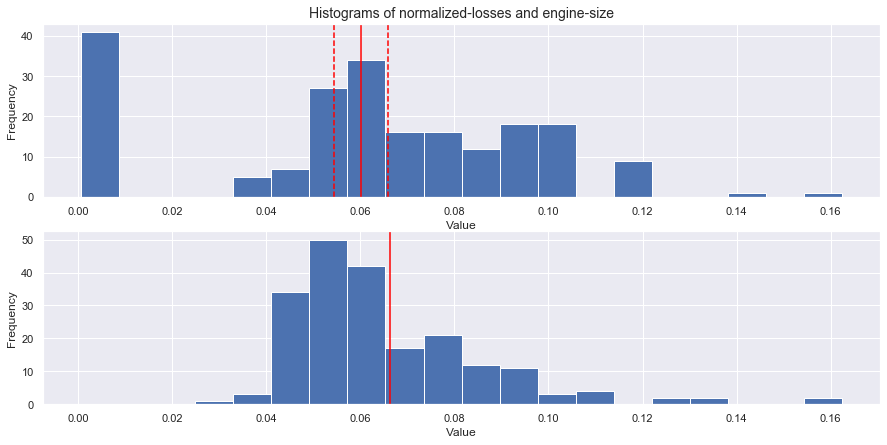


       HORSEPOWER
DegFreedom    370.939340
Difference     -0.004849
Statistic      -1.580944
PValue          0.114743
Low95CI        -0.010880
High95CI        0.001182
dtype: float64


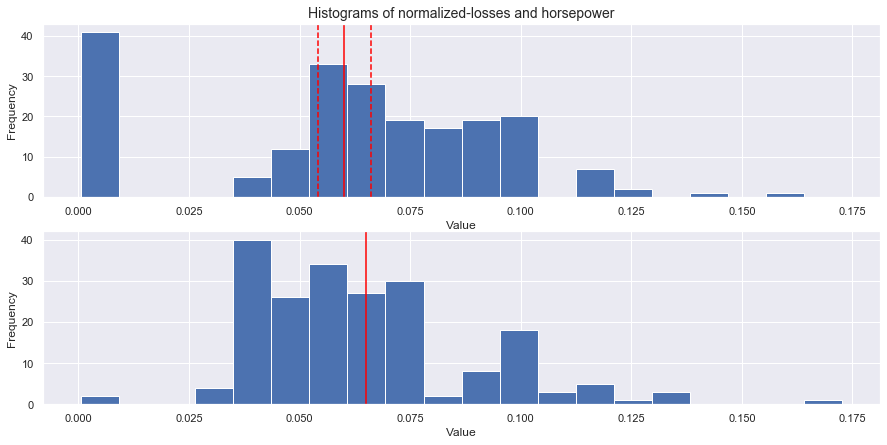


    COMPRESSION-RATIO
DegFreedom    369.404222
Difference     -0.004929
Statistic      -1.611303
PValue          0.107968
Low95CI        -0.010944
High95CI        0.001086
dtype: float64


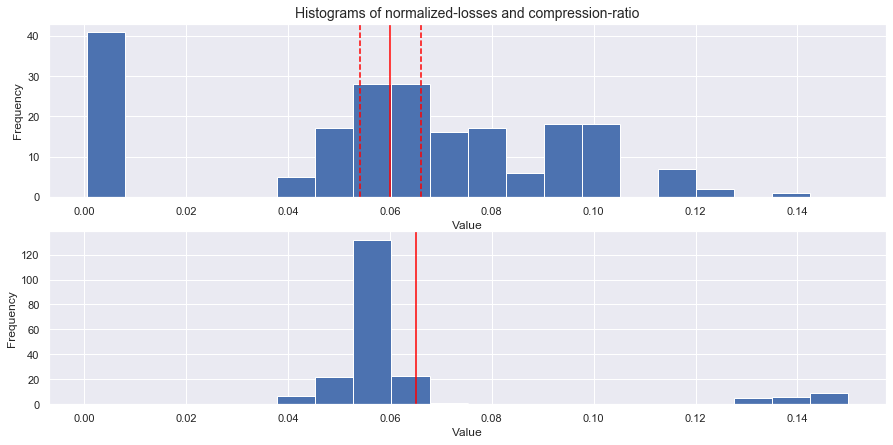

In [35]:
print('\n       ENGINE-SIZE')
features = ['normalized-losses', 'engine-size']
helper_tTest(auto_df, features)
print('\n       HORSEPOWER')
features = ['normalized-losses', 'horsepower']
helper_tTest(auto_df, features)
print('\n    COMPRESSION-RATIO')
features = ['normalized-losses', 'compression-ratio']
helper_tTest(auto_df, features)

> - The following plots compare other aspects of the auto dataset, that are statistically significant.  
> - These results are with respect to 'Symboling'


       ENGINE-SIZE
DegFreedom    2.601806e+02
Difference   -2.744281e-02
Statistic    -6.330012e+00
PValue        1.067711e-09
Low95CI      -3.597965e-02
High95CI     -1.890597e-02
dtype: float64


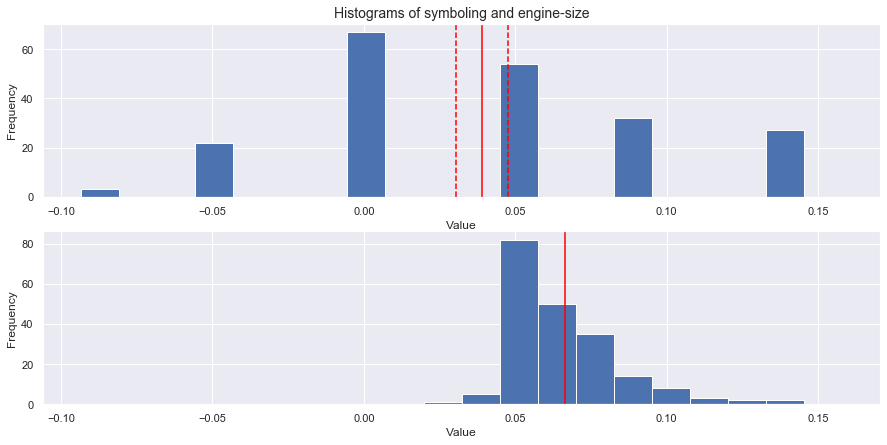


       HORSEPOWER
DegFreedom    2.807170e+02
Difference   -2.604054e-02
Statistic    -5.867288e+00
PValue        1.245135e-08
Low95CI      -3.477704e-02
High95CI     -1.730405e-02
dtype: float64


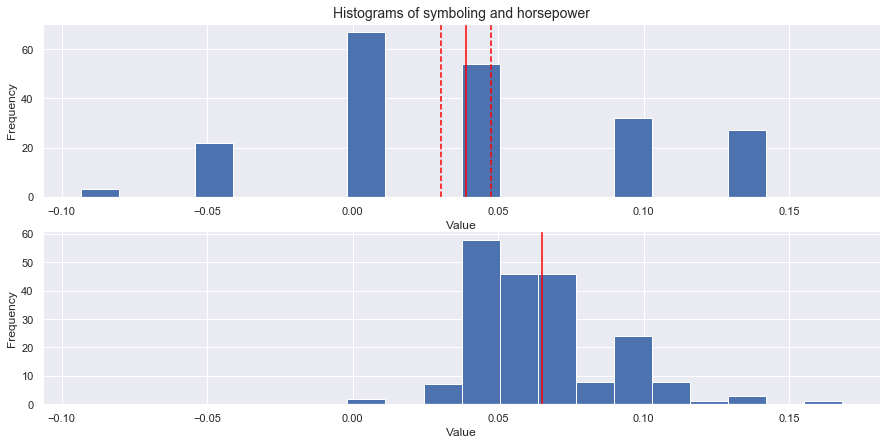


    COMPRESSION-RATIO
DegFreedom    2.795918e+02
Difference   -2.612029e-02
Statistic    -5.892864e+00
PValue        1.089379e-08
Low95CI      -3.484566e-02
High95CI     -1.739492e-02
dtype: float64


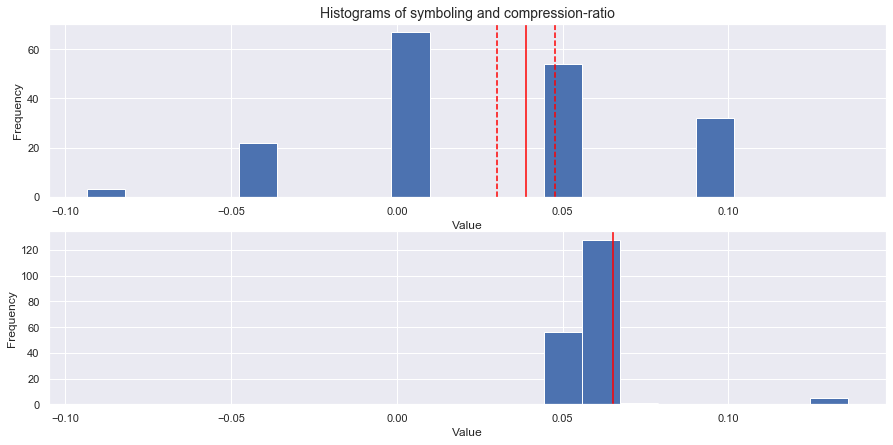

In [36]:
print('\n       ENGINE-SIZE')
features = ['symboling', 'engine-size']
helper_tTest(auto_df, features)
print('\n       HORSEPOWER')
features = ['symboling', 'horsepower']
helper_tTest(auto_df, features)
print('\n    COMPRESSION-RATIO')
features = ['symboling', 'compression-ratio']
helper_tTest(auto_df, features)


          LENGTH
DegFreedom    2.069449e+02
Difference   -3.073446e-02
Statistic    -7.543461e+00
PValue        1.422227e-12
Low95CI      -3.876695e-02
High95CI     -2.270197e-02
dtype: float64


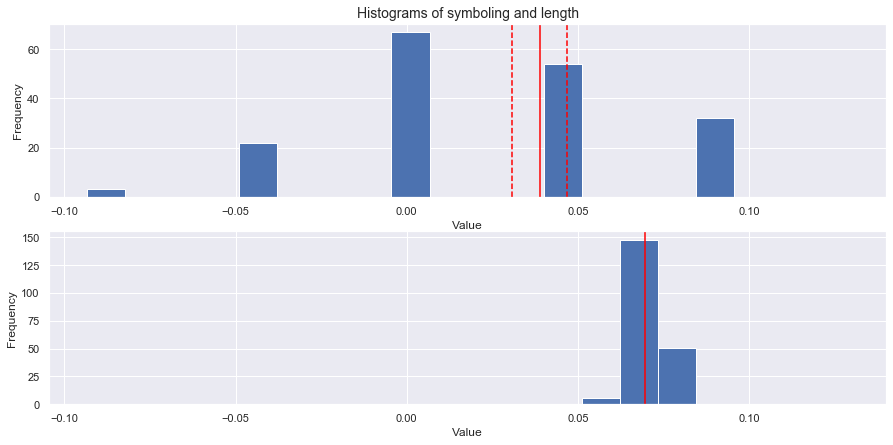


          WIDTH
DegFreedom    2.046234e+02
Difference   -3.087163e-02
Statistic    -7.598623e+00
PValue        1.055142e-12
Low95CI      -3.888193e-02
High95CI     -2.286132e-02
dtype: float64


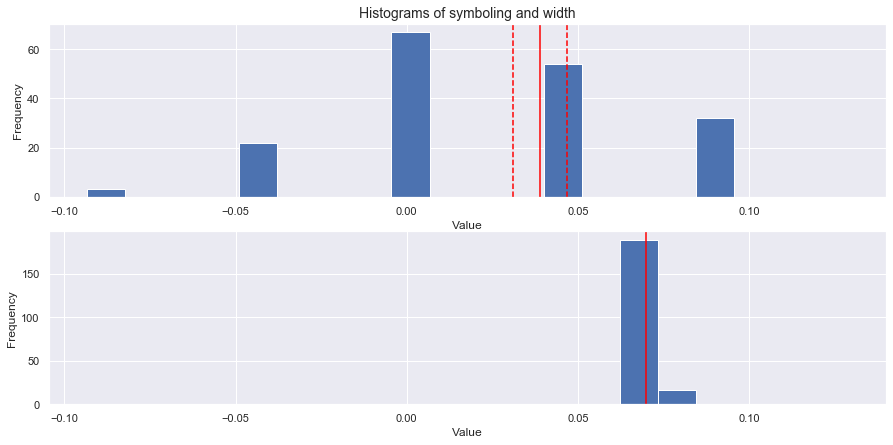


          HEIGHT
DegFreedom    2.052160e+02
Difference   -3.083664e-02
Statistic    -7.584512e+00
PValue        1.138790e-12
Low95CI      -3.885261e-02
High95CI     -2.282066e-02
dtype: float64


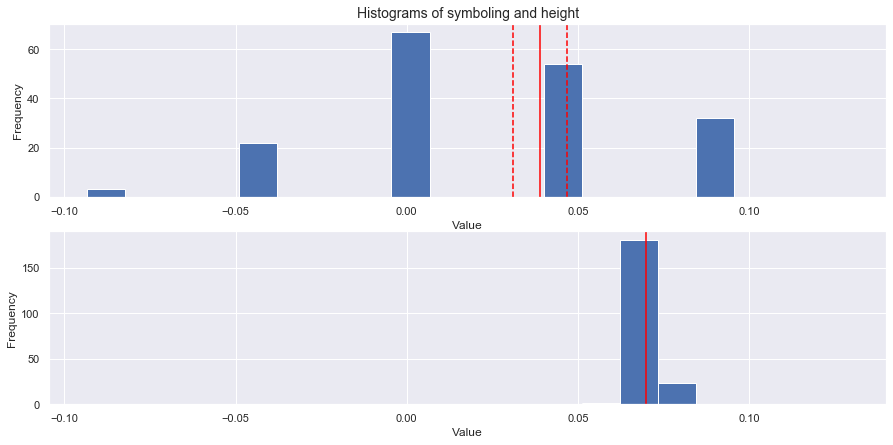

In [37]:
print('\n          LENGTH')
features = ['symboling', 'length']
helper_tTest(auto_df, features)
print('\n          WIDTH')
features = ['symboling', 'width']
helper_tTest(auto_df, features)
print('\n          HEIGHT')
features = ['symboling', 'height']
helper_tTest(auto_df, features)

> - Here is a clear example, where the t-test does not permit the null hypothesis to be dismissed, between 'Engine-Size' and 'Number-of-Cylinders'.


       ENGINE-SIZE
DegFreedom    382.600680
Difference     -0.001441
Statistic      -0.751377
PValue          0.452888
Low95CI        -0.005213
High95CI        0.002330
dtype: float64


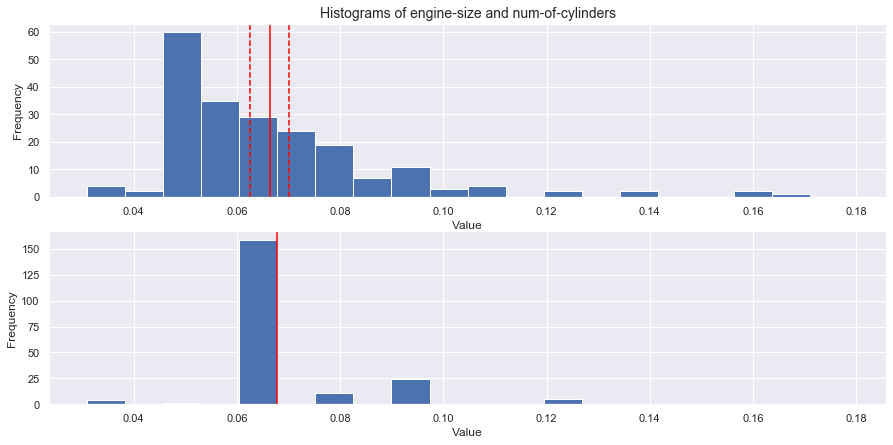

In [38]:
print('\n       ENGINE-SIZE')
features = ['engine-size', 'num-of-cylinders']
helper_tTest(auto_df, features)

### Tukey's HSD Hypothesis Test  
> Observe the results, where features evaluated are given in the box plot results, above:  
> - The only null hypothesis accepted for feature 'Normalized-Losses' are 'Compression-Ratio', 'Engine-Size', and 'Horsepower'.  
> - None of the null hypothesis are accepted for feature 'Symboling'.  
> - The only features that reject the null hypothesis are 'Normalized-Losses' and 'Symboling'.

In [39]:
df = get_Groups(auto_df)
Tukey_HSD = pairwise_tukeyhsd(df.vals, df.group_num)
print(Tukey_HSD)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
               bore              city-mpg    -0.0017    0.9 -0.0089  0.0056  False
               bore     compression-ratio    -0.0042 0.8301 -0.0115   0.003  False
               bore           curb-weight    -0.0008    0.9 -0.0081  0.0064  False
               bore        engine-loction     0.0001    0.9 -0.0072  0.0073  False
               bore           engine-size    -0.0029    0.9 -0.0101  0.0043  False
               bore                height     0.0005    0.9 -0.0068  0.0077  False
               bore           highway-mpg    -0.0011    0.9 -0.0084  0.0061  False
               bore            horsepower    -0.0043 0.8049 -0.0115  0.0029  False
               bore                length     0.0004    0.9 -0.0069  0.0076  False
    

### Boostrap Hypothesis Test  
> - The following histogram plots give direct comparison to those results previously shown for the derivation of Classical hypothesis testing.  
> - Although the plotted distibutions here are not identical to those previously derived, the null hypothesis is generally concluded with the same outcomes.

In [40]:
# bootstrap the means
n_replicas = 1000
bs_means = pd.DataFrame([
    classicalStats_df.sample(frac=1, replace=True).mean() for i in range(n_replicas)])


       SYMBOLING
DegFreedom    1.299448e+03
Difference    4.670576e-03
Statistic     7.745522e+00
PValue        1.905874e-14
Low95CI       3.487609e-03
High95CI      5.853543e-03
dtype: float64


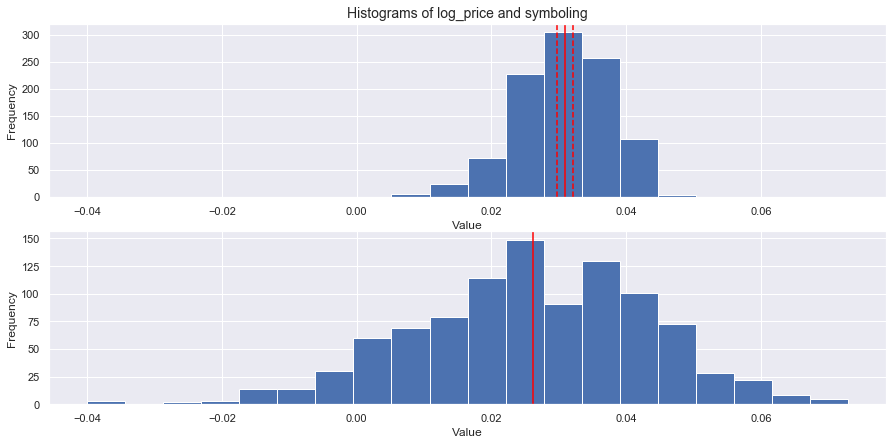


   NORMALIZED-LOSSES
DegFreedom    1922.264073
Difference       0.000392
Statistic        1.125365
PValue           0.260575
Low95CI         -0.000291
High95CI         0.001074
dtype: float64


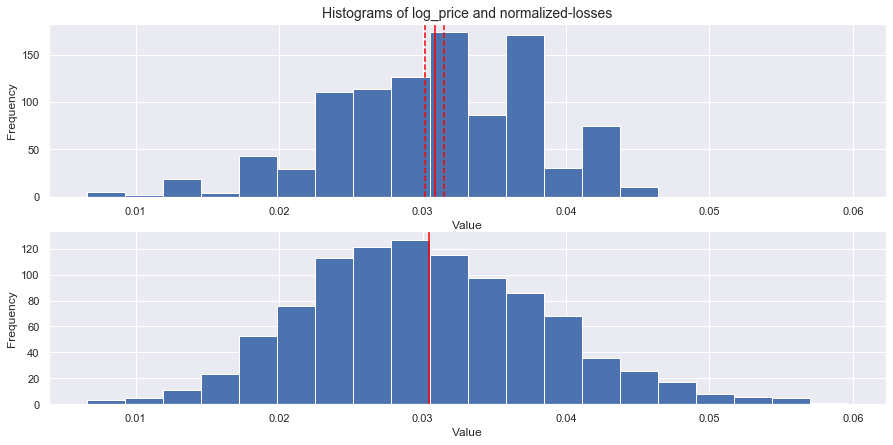

In [41]:
print('\n       SYMBOLING')
features = ['log_price', 'symboling']
helper_tTest(bs_means, features)
print('\n   NORMALIZED-LOSSES')
features = ['log_price', 'normalized-losses']
helper_tTest(bs_means, features)


       ENGINE-SIZE
DegFreedom    1989.066576
Difference      -0.000149
Statistic       -0.404284
PValue           0.686047
Low95CI         -0.000872
High95CI         0.000574
dtype: float64


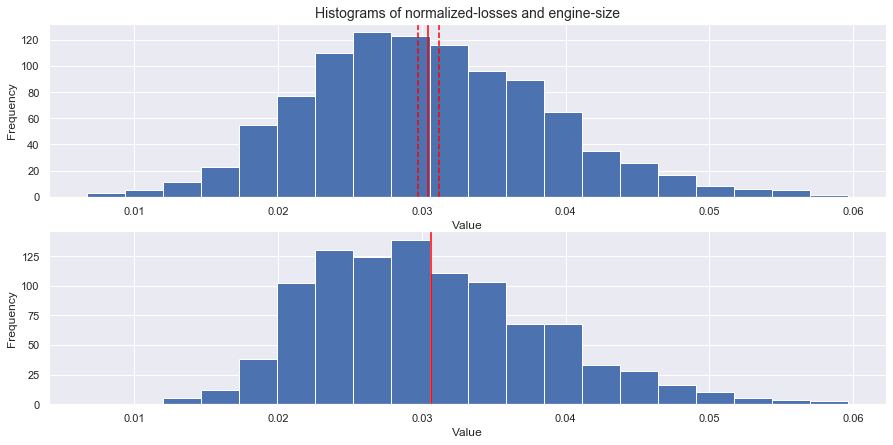


       HORSEPOWER
DegFreedom    1957.829818
Difference       0.000400
Statistic        0.973080
PValue           0.330634
Low95CI         -0.000407
High95CI         0.001207
dtype: float64


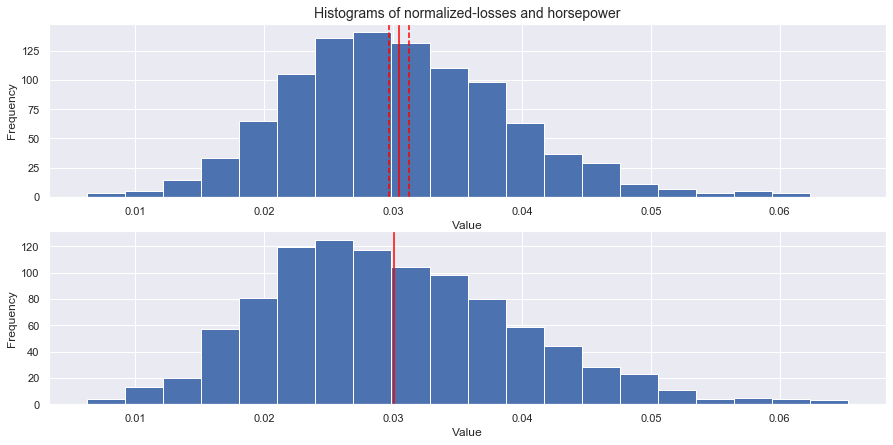


    COMPRESSION-RATIO
DegFreedom    1884.889640
Difference      -0.000465
Statistic       -1.361064
PValue           0.173656
Low95CI         -0.001134
High95CI         0.000205
dtype: float64


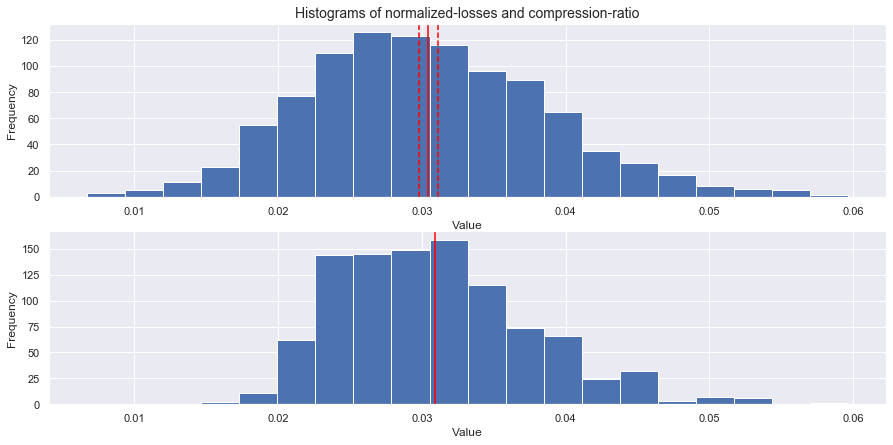

In [42]:
print('\n       ENGINE-SIZE')
features = ['normalized-losses', 'engine-size']
helper_tTest(bs_means, features)
print('\n       HORSEPOWER')
features = ['normalized-losses', 'horsepower']
helper_tTest(bs_means, features)
print('\n    COMPRESSION-RATIO')
features = ['normalized-losses', 'compression-ratio']
helper_tTest(bs_means, features)


       ENGINE-SIZE
DegFreedom    1.385479e+03
Difference   -4.428121e-03
Statistic    -7.197322e+00
PValue        1.003010e-12
Low95CI      -5.635035e-03
High95CI     -3.221207e-03
dtype: float64


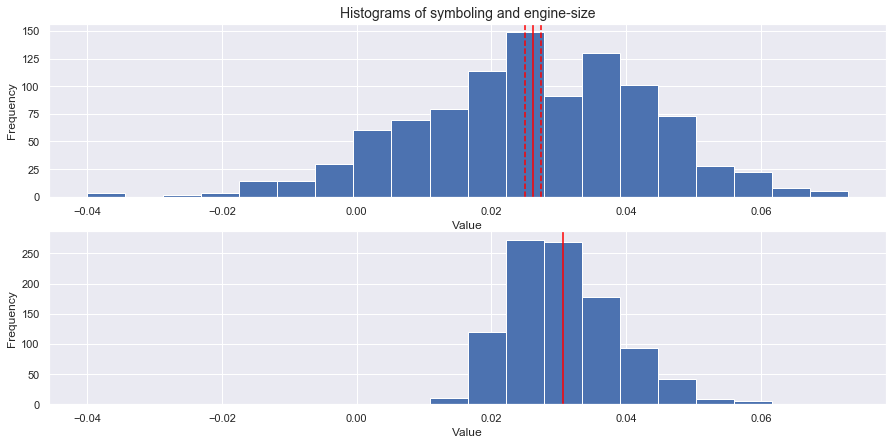


       HORSEPOWER
DegFreedom    1.559782e+03
Difference   -3.878650e-03
Statistic    -6.043509e+00
PValue        1.882769e-09
Low95CI      -5.137507e-03
High95CI     -2.619792e-03
dtype: float64


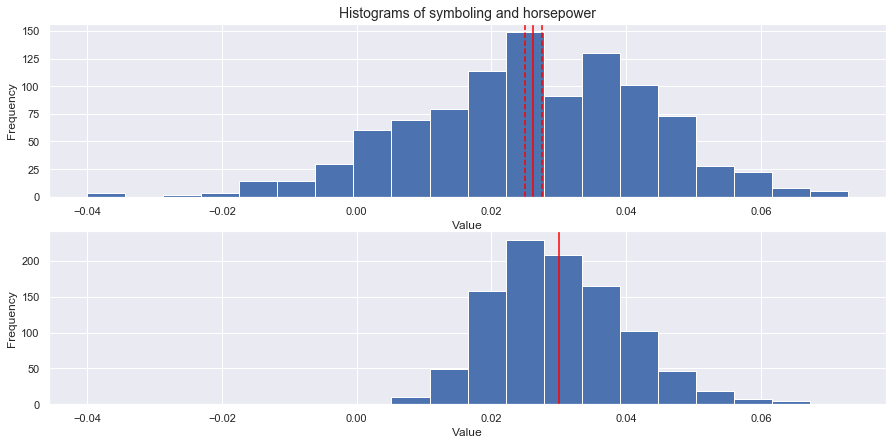


    COMPRESSION-RATIO
DegFreedom    1.272586e+03
Difference   -4.743655e-03
Statistic    -7.916051e+00
PValue        5.299650e-15
Low95CI      -5.919272e-03
High95CI     -3.568038e-03
dtype: float64


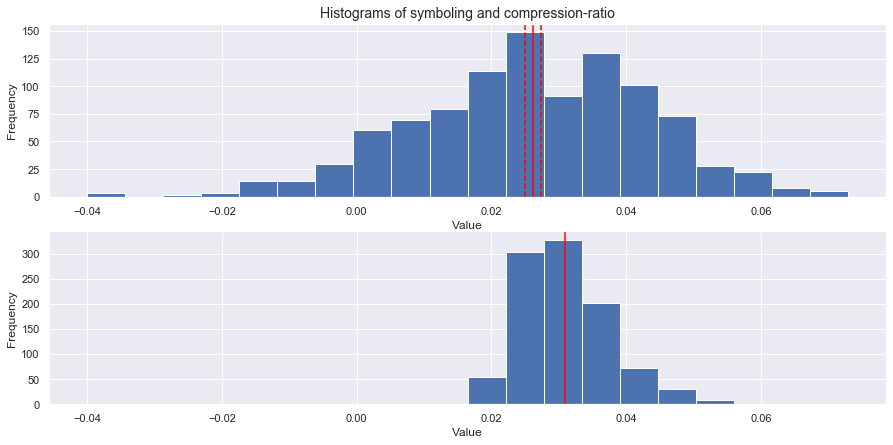

In [43]:
print('\n       ENGINE-SIZE')
features = ['symboling', 'engine-size']
helper_tTest(bs_means, features)
print('\n       HORSEPOWER')
features = ['symboling', 'horsepower']
helper_tTest(bs_means, features)
print('\n    COMPRESSION-RATIO')
features = ['symboling', 'compression-ratio']
helper_tTest(bs_means, features)


          LENGTH
DegFreedom    1.133882e+03
Difference   -5.106907e-03
Statistic    -8.804011e+00
PValue        4.844168e-18
Low95CI      -6.245030e-03
High95CI     -3.968784e-03
dtype: float64


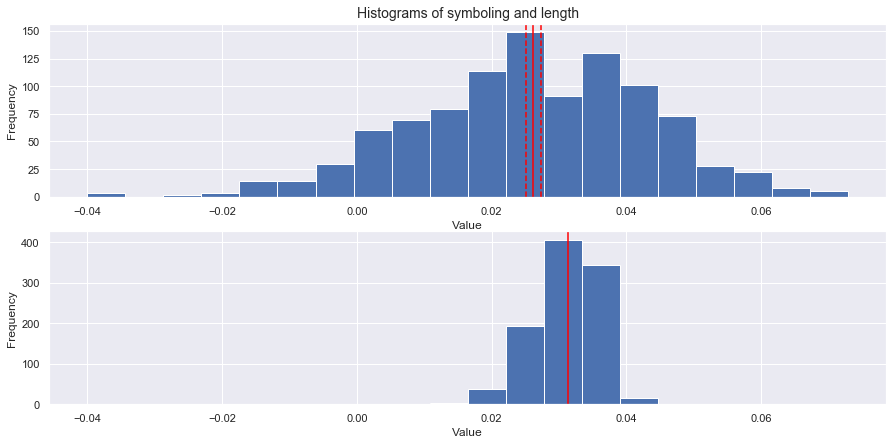


          WIDTH
DegFreedom    1.133739e+03
Difference   -5.107273e-03
Statistic    -8.804941e+00
PValue        4.807490e-18
Low95CI      -6.245357e-03
High95CI     -3.969188e-03
dtype: float64


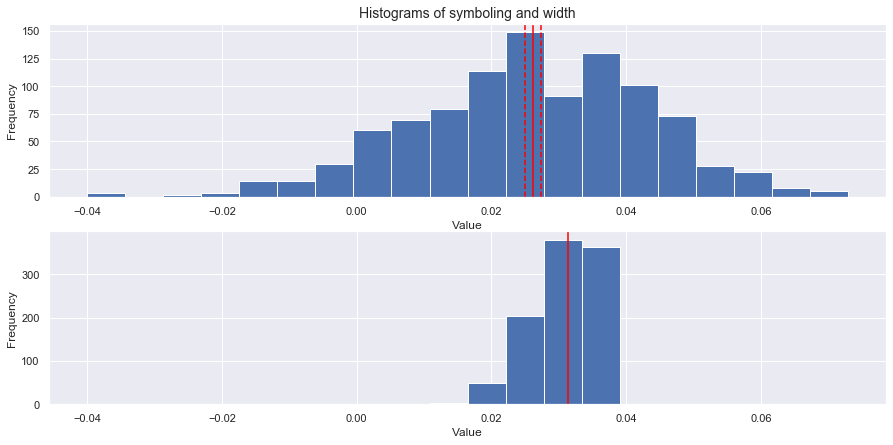


          HEIGHT
DegFreedom    1.131663e+03
Difference   -5.112571e-03
Statistic    -8.818426e+00
PValue        4.305398e-18
Low95CI      -6.250097e-03
High95CI     -3.975046e-03
dtype: float64


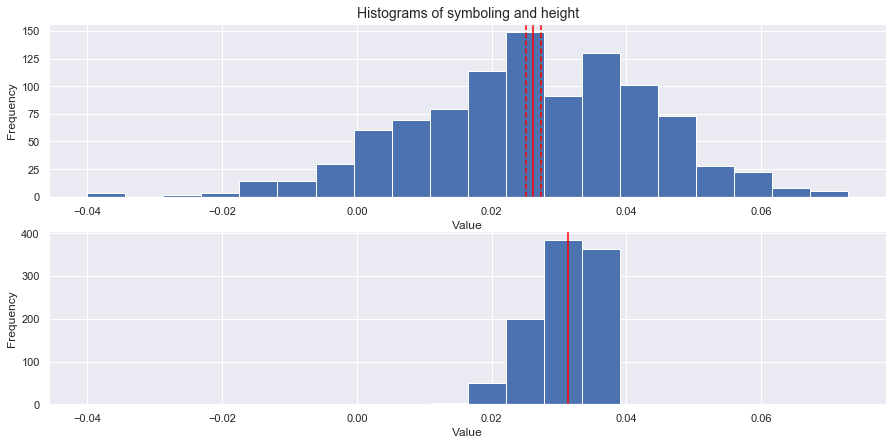

In [44]:
print('\n          LENGTH')
features = ['symboling', 'length']
helper_tTest(bs_means, features)
print('\n          WIDTH')
features = ['symboling', 'width']
helper_tTest(bs_means, features)
print('\n          HEIGHT')
features = ['symboling', 'height']
helper_tTest(bs_means, features)


       ENGINE-SIZE
DegFreedom    1984.563157
Difference       0.000186
Statistic        0.500801
PValue           0.616567
Low95CI         -0.000543
High95CI         0.000915
dtype: float64


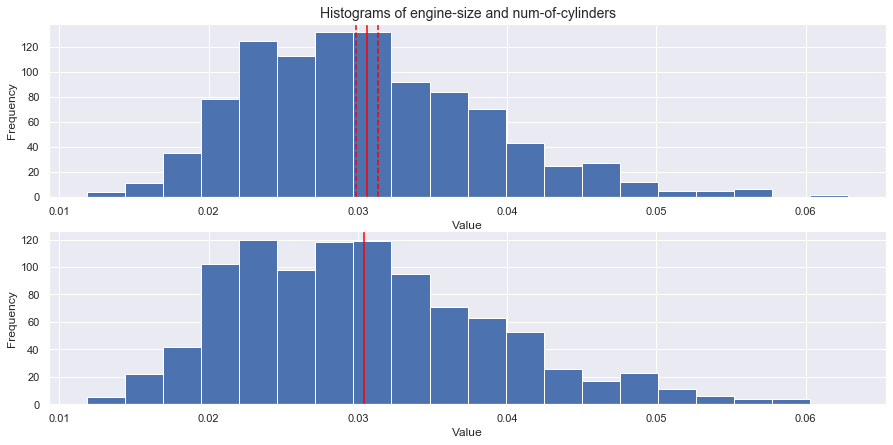

In [45]:
print('\n       ENGINE-SIZE')
features = ['engine-size', 'num-of-cylinders']
helper_tTest(bs_means, features)

### Bayesian Hypothesis Test  
> - Use a log-normal distribution to evaluate the hypothesis test using a Bayesian approach.  
> - The preceding histogram plot results are once again dervied below.

In [46]:
# get the log-normal distribution of the auto dataset features
bayesian_df = get_LogNormal(auto_df, strFeatures)


       SYMBOLING
DegFreedom    2.352574e+02
Difference    2.316645e-02
Statistic     5.977356e+00
PValue        8.346332e-09
Low95CI       1.553094e-02
High95CI      3.080197e-02
dtype: float64


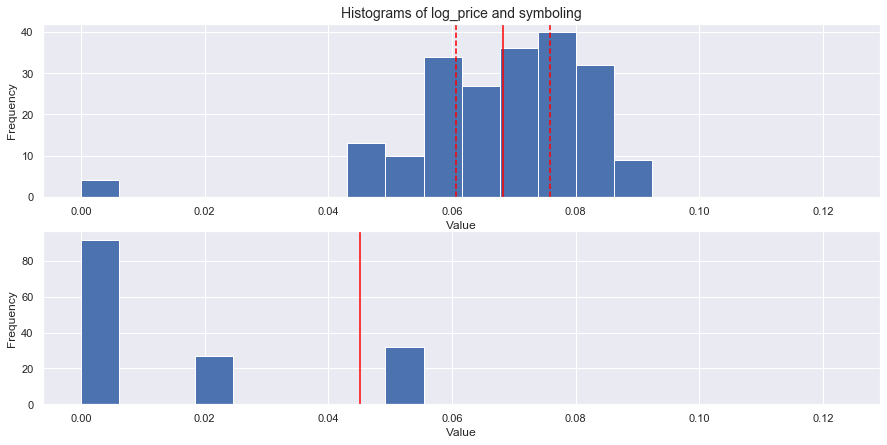


   NORMALIZED-LOSSES
DegFreedom    2.268512e+02
Difference    3.702056e-02
Statistic     8.236073e+00
PValue        1.410907e-14
Low95CI       2.816341e-02
High95CI      4.587771e-02
dtype: float64


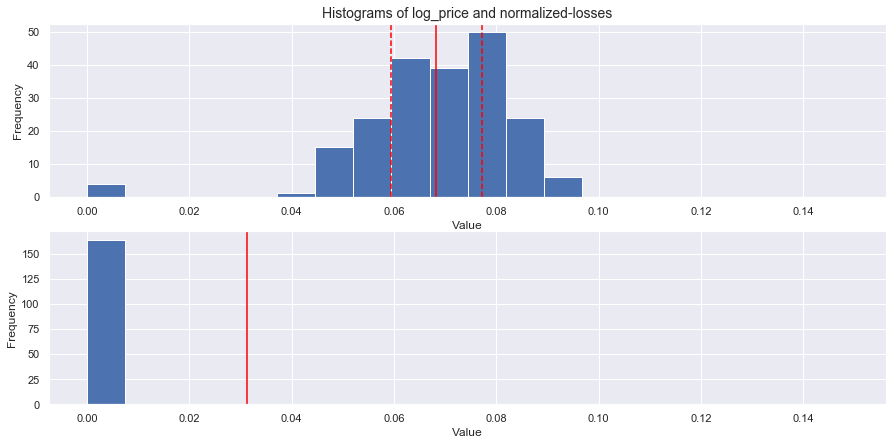

In [47]:
print('\n       SYMBOLING')
features = ['log_price', 'symboling']
helper_tTest(bayesian_df, features)
print('\n   NORMALIZED-LOSSES')
features = ['log_price', 'normalized-losses']
helper_tTest(bayesian_df, features)


       ENGINE-SIZE
DegFreedom    407.332975
Difference     -0.004531
Statistic      -0.747143
PValue          0.455408
Low95CI        -0.016451
High95CI        0.007390
dtype: float64


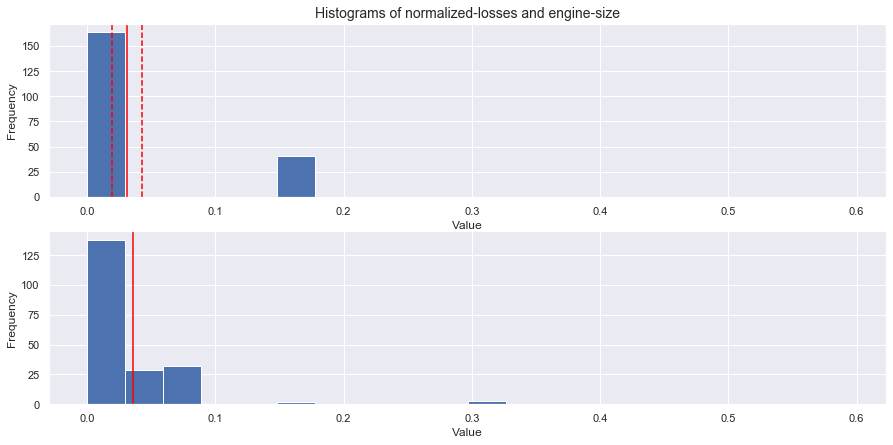


       HORSEPOWER
DegFreedom    403.444090
Difference      0.024336
Statistic       3.719434
PValue          0.000228
Low95CI         0.011473
High95CI        0.037198
dtype: float64


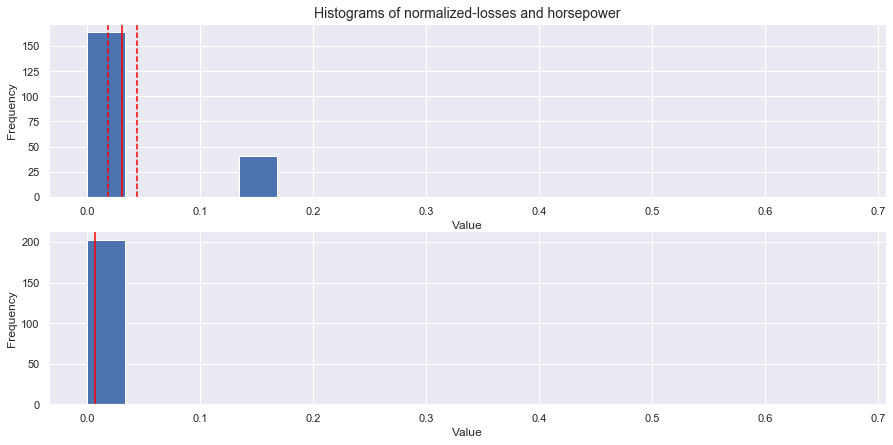


    COMPRESSION-RATIO
DegFreedom    2.831609e+02
Difference   -3.271844e-02
Statistic    -6.823380e+00
PValue        5.391848e-11
Low95CI      -4.215691e-02
High95CI     -2.327998e-02
dtype: float64


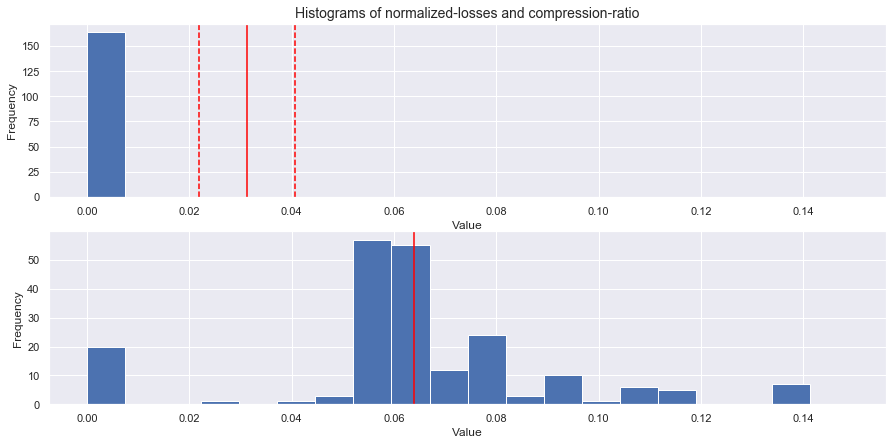

In [48]:
print('\n       ENGINE-SIZE')
features = ['normalized-losses', 'engine-size']
helper_tTest(bayesian_df, features)
print('\n       HORSEPOWER')
features = ['normalized-losses', 'horsepower']
helper_tTest(bayesian_df, features)
print('\n    COMPRESSION-RATIO')
features = ['normalized-losses', 'compression-ratio']
helper_tTest(bayesian_df, features)

> - The following plot result is unique in the results thus far derived, in that feature 'Symboling' does not reject the 'Engine-Size' feature.


       ENGINE-SIZE
DegFreedom    402.491686
Difference      0.009323
Statistic       1.658892
PValue          0.097917
Low95CI        -0.001725
High95CI        0.020372
dtype: float64


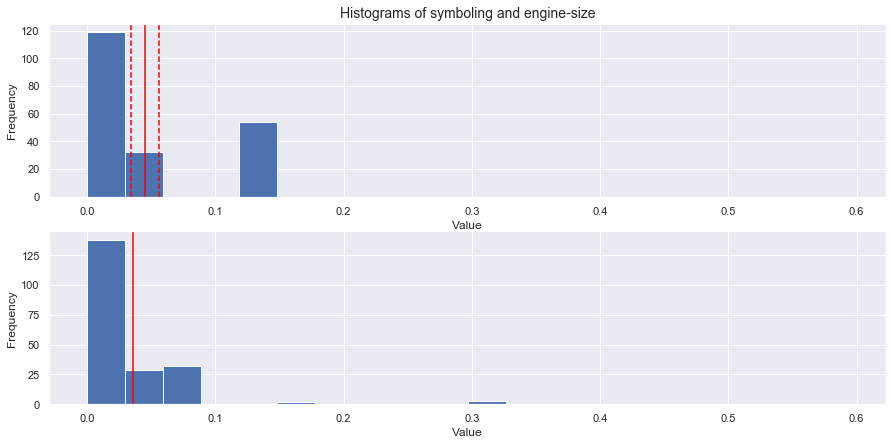


       HORSEPOWER
DegFreedom    3.824130e+02
Difference    3.818963e-02
Statistic     6.225977e+00
PValue        1.260295e-09
Low95CI       2.612920e-02
High95CI      5.025006e-02
dtype: float64


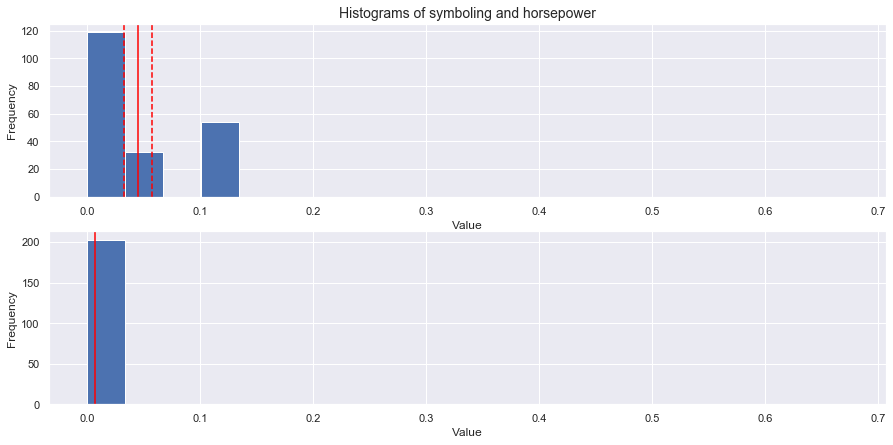


    COMPRESSION-RATIO
DegFreedom    308.957405
Difference     -0.018864
Statistic      -4.470124
PValue          0.000011
Low95CI        -0.027168
High95CI       -0.010561
dtype: float64


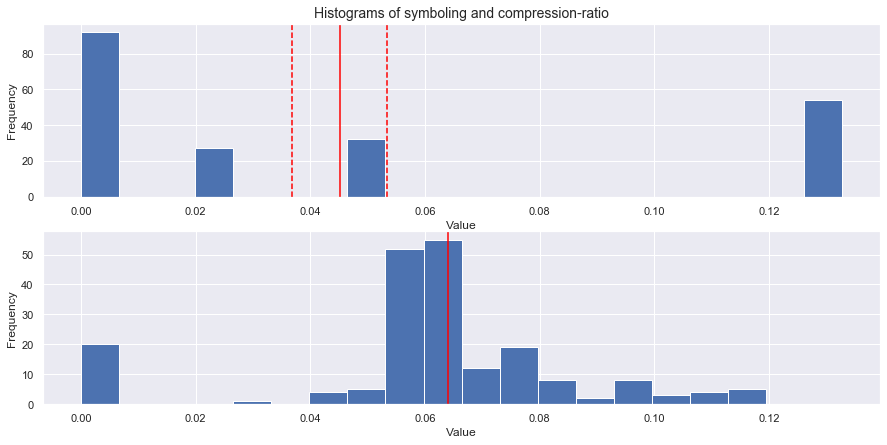

In [49]:
print('\n       ENGINE-SIZE')
features = ['symboling', 'engine-size']
helper_tTest(bayesian_df, features)
print('\n       HORSEPOWER')
features = ['symboling', 'horsepower']
helper_tTest(bayesian_df, features)
print('\n    COMPRESSION-RATIO')
features = ['symboling', 'compression-ratio']
helper_tTest(bayesian_df, features)


          LENGTH
DegFreedom    315.385392
Difference     -0.018415
Statistic      -4.329752
PValue          0.000020
Low95CI        -0.026784
High95CI       -0.010047
dtype: float64


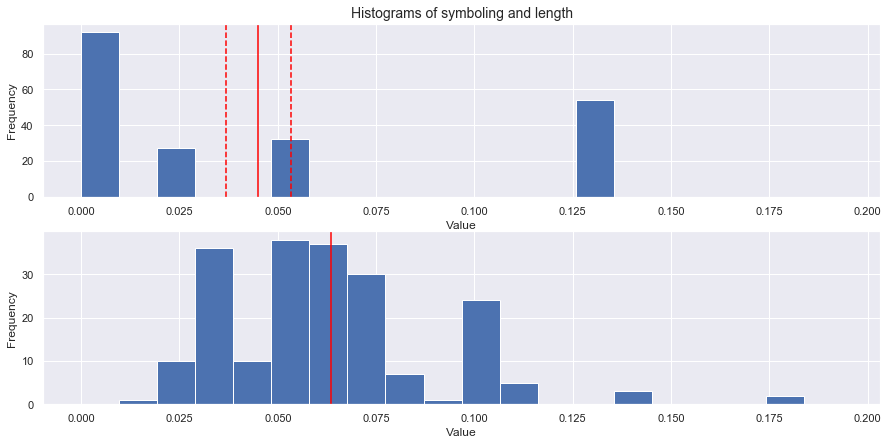


          WIDTH
DegFreedom    2.207389e+02
Difference   -2.391204e-02
Statistic    -6.275409e+00
PValue        1.821462e-09
Low95CI      -3.142153e-02
High95CI     -1.640255e-02
dtype: float64


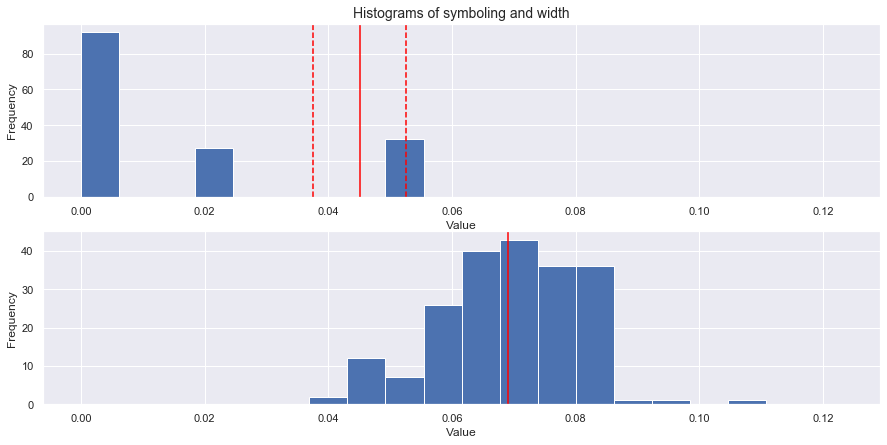


          HEIGHT
DegFreedom    2.382468e+02
Difference   -2.301055e-02
Statistic    -5.916645e+00
PValue        1.135514e-08
Low95CI      -3.067201e-02
High95CI     -1.534910e-02
dtype: float64


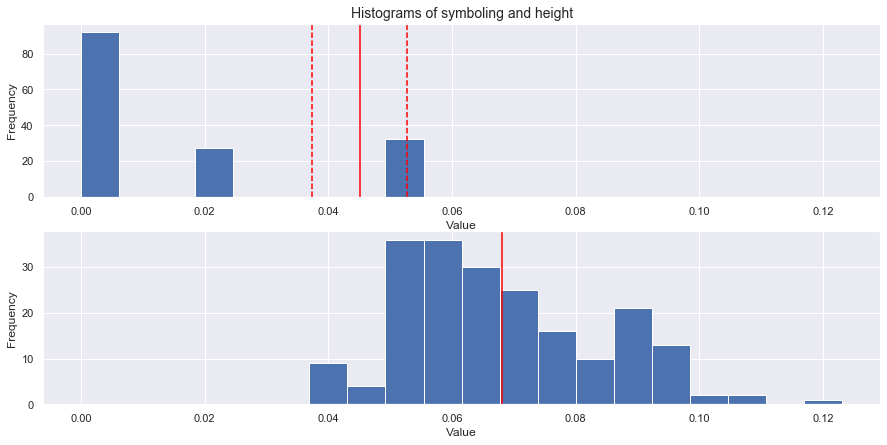

In [50]:
print('\n          LENGTH')
features = ['symboling', 'length']
helper_tTest(bayesian_df, features)
print('\n          WIDTH')
features = ['symboling', 'width']
helper_tTest(bayesian_df, features)
print('\n          HEIGHT')
features = ['symboling', 'height']
helper_tTest(bayesian_df, features)

> - Unlike the previously returned histogram results of 'Engine-Size' and 'Number-of-Cylinders' (REF: 'Bootstrap Hypothesis Test' and 'Classical Hypothesis Test'), the null hypothesis that these 2 features are not different is for the first time rejected.


       ENGINE-SIZE
DegFreedom    3.216986e+02
Difference   -2.535047e-02
Statistic    -5.258118e+00
PValue        2.658968e-07
Low95CI      -3.483555e-02
High95CI     -1.586540e-02
dtype: float64


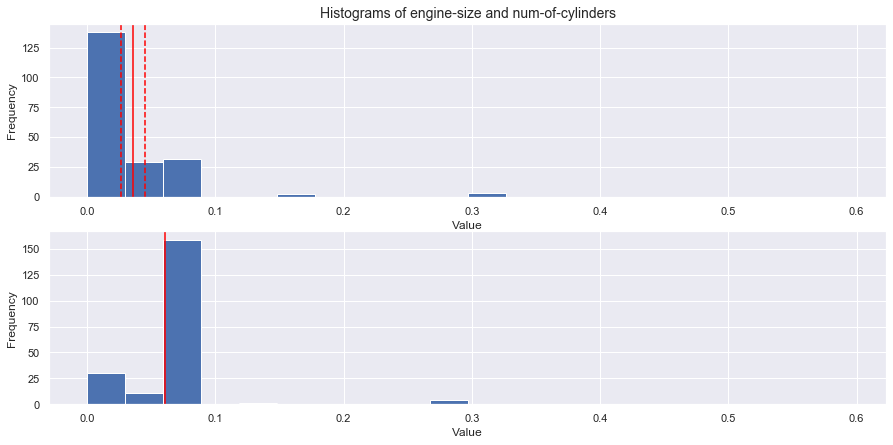

In [51]:
print('\n       ENGINE-SIZE')
features = ['engine-size', 'num-of-cylinders']
helper_tTest(bayesian_df, features)